In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import emcee 
import pyimfit 
from astropy.io import fits
import corner
from IPython.display import Latex
import sys
import warnings
from matplotlib.ticker import LogFormatter
import pickle

from photutils.detection import find_peaks
from photutils.aperture import CircularAperture
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils.psf import EPSFBuilder
from photutils import profiles
from astropy.table import Table

medium_font_size = 10
plt.rcParams['font.size'] = medium_font_size
plt.rcParams['axes.labelsize'] = medium_font_size
plt.rcParams['axes.titlesize'] = medium_font_size
plt.rcParams['xtick.labelsize'] = medium_font_size
plt.rcParams['ytick.labelsize'] = medium_font_size


plt.rcParams['font.family'] = 'monospace'
plt.rcParams['image.cmap'] = 'gray'
warnings.filterwarnings("ignore")

imageAGN = fits.getdata("../fit/agn.fits")

#sourceFile = "../../agn-data/2020-02-21_J_J0901+1815_c1-4_58900_12932.mos.fits"
sourceFile = "../../agn-data/2020-02-21_J_J1215+1344_c1-4_58900_32019.mos.fits"

data = fits.getdata(sourceFile)

In [2]:
def find_peaks_remove_dups(Imin):
    """Find peaks with pixel value > Imin
       remove duplicate values of x_peak
       find indices of detections that are too close/erred
       Return peak table with no duplicates and list of indices of close detections"""
    # FIND PEAKS
    peaks_tbl = find_peaks(data, threshold=Imin)   
    
    # Cleaning
    # search and remove sources with same x values, keeping only first finds
    df = peaks_tbl.to_pandas().sort_values(by='x_peak')
    dups = df.duplicated(subset="x_peak",keep="first")
    nodups = df[~dups]
    # list to remove sources with separation in x and y < 10 pixels 
    indices_to_drop = []
    for i in range(len(nodups)-1):
        if abs(nodups.iloc[i+1]['x_peak'] - nodups.iloc[i]['x_peak']) < 10 and abs(nodups.iloc[i+1]['y_peak'] - nodups.iloc[i]['y_peak']) < 10:
            indices_to_drop.append(nodups.iloc[i+1].name)
            indices_to_drop.append(nodups.iloc[i].name)

    indices_to_drop=list((set(indices_to_drop)))
    return nodups, indices_to_drop
    
    
def plot_erred_star_peaks(nodups,indices_to_drop,figfile):
    """plot duplicates detections that turns out to be erred stars"""
    nodups.loc[indices_to_drop].sort_values('x_peak')
    ncols = 6
    nrows = int(np.ceil(len(indices_to_drop)/ncols))
    fig,ax = plt.subplots(nrows,ncols,figsize=(ncols*2,nrows*2))
    ax = ax.ravel()
    for i in range(len(indices_to_drop)):
        y=int(nodups.loc[indices_to_drop[i]]['y_peak'])
        x=int(nodups.loc[indices_to_drop[i]]['x_peak'])
        px=30
        ax[i].imshow(data[y-px:y+px,x-px:x+px], origin='lower', cmap='viridis')
        ax[i].set_title(f"{x},{y}",fontsize=5)
    [ax[-i].axis('off') for i in range(1,len(ax)-len(indices_to_drop)+1)]
    fig.suptitle("Erred and duplicate detections of peaks",y=1.0)
    fig.tight_layout()
    fig.savefig(figfile)
    
    
def drop_erred_peaks(nodups, indices_to_drop):
    """drop erred indices from indice_to_drop from nodups,  returns table of sources position and pixel counts"""
    peaks_tbl = nodups.drop(indices_to_drop)
    return peaks_tbl


def plot_sources(peaks_tbl):
    """plot detected sources on the sky exposure"""
    positions = np.transpose((peaks_tbl['x_peak'], peaks_tbl['y_peak']))
    apertures = CircularAperture(positions, r=10.0)
    norm = simple_norm(data, 'log', percent=99.9)
    plt.figure(figsize=(12,12))
    plt.imshow(data, cmap='Greys_r', origin='lower', norm=norm,
               interpolation='nearest')
    apertures.plot(color='#0547f9', lw=0.5)
    plt.xlim(0, data.shape[1] - 1)
    plt.ylim(0, data.shape[0] - 1);
    
    
def plot_stars(stars):
    """plotting a table of star stamps"""
    nrows = int(np.ceil(len(stars)/4))
    ncols = 4
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(int(ncols*2), int(nrows*2)),
                           squeeze=True)
    ax = ax.ravel()
    for i in range(len(stars)):
        norm = simple_norm(stars[i], 'log', percent=99.0)
        im = ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
        ax[i].set_title(i)
        colorbar = fig.colorbar(im, ax=ax[i], shrink=0.8)
        colorbar.ax.yaxis.set_major_locator(plt.MaxNLocator(2))
    # turn off empty axes
    empty_axes = nrows*ncols-len(stars)
    [ax[-i].axis('off') for i in np.arange(1,empty_axes+1)]
    fig.tight_layout()
    fig.suptitle("Star ensemble for ePSF construction")
    
    
def make_star_cutout(peaks_tbl):
    """make 35x35 pixels star cutouts from peaks_tbl"""
    # size of a star cutout
    size = 35
    hsize = (size - 1) / 2
    x = peaks_tbl['x_peak']  
    y = peaks_tbl['y_peak']  
    # remove stars that are too close to edges
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize))) 
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]  
    stars_tbl['y'] = y[mask]
    # extract stamps
    nddata = NDData(data=data)
    stars = extract_stars(nddata, stars_tbl, size=35)
    return stars_tbl, stars


def drop_star_stamps(stars_tbl,d400=True):
    drop100=[0,1,2,7,8,9,12,13,14,15,17,19,22,23,31,36,45,46,48,49,50,51,53,54,55,57,59,
              65,66,67,71,72,75,78,79,80,82,83,85,90,91,92,95,96,98,99,101,102]
    drop400=[0,1,4,13,18]
    if d400:
        stars_tbl.remove_rows(drop400)
    else:
        stars_tbl.remove_rows(drop100)
    nddata = NDData(data=data)
    stars = extract_stars(nddata, stars_tbl, size=35)
    return stars


def build_psf(stars,osamp,shp,k='quartic',norm_r=20,maxit=30):
    """build epsf from star ensemble"""
    epsf_builder = EPSFBuilder(oversampling=osamp,shape=shp,smoothing_kernel=k,norm_radius=norm_r,maxiters=maxit) 
    epsf, fitted_stars = epsf_builder(stars) 
    return epsf,fitted_stars


def plot_psfs(epsf, epsf1, osamp):
    """plot to compare oversampled and not oversampled psfs"""
    fig,ax = plt.subplots(1,2)
    im0 = ax[0].imshow(epsf.data, cmap='viridis')
    im1= ax[1].imshow(epsf1.data, cmap='viridis')
    [fig.colorbar([im0,im1][i], ax=[ax[0],ax[1]][i],shrink=0.3) for i in range(2)]
    [ax[i].set_title([f'Oversampled PSF (x{osamp})', "PSF"][i]) for i in range(2)]
    fig.tight_layout();
    
def save_psf(epsf, filename):
    """save psf to fits file"""
    hdu = fits.PrimaryHDU(epsf.data)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(filename, overwrite=True)

In [3]:
# find peaks and remove duplicates, erred detections
nodups, indices_to_drop = find_peaks_remove_dups(400)
#---plot_erred_star_peaks(nodups,indices_to_drop)
# drop erred detections 
peaks_tbl = drop_erred_peaks(nodups, indices_to_drop)
# make star stamps
stars_tbl, stars = make_star_cutout(peaks_tbl)
# drop weird stars and make stamps again
stars = drop_star_stamps(stars_tbl,d400=True)
# plot star stamps
#---plot_stars(stars)
# make psfs and plot
#epsf,fitted_stars = build_psf(stars,2,shp=None,k='quadratic')
epsf1,fitted_stars1 = build_psf(stars,1,shp=(35,35),k='quartic')
#plot_psfs(epsf,epsf1,2)

EPSFBuilder (30 maxiters):   0%|          | 0/30 [00:00<?, ?it/s]

EPSFBuilder converged after 6 iterations (of 30 maximum iterations)


In [72]:
with open('../psfConstruction/psf_pkls/psf_J0901+1815.pkl',"rb") as f:
    d = pickle.load(f)
d


{'psf': <EPSFModel(flux=1., x_0=0., y_0=0.)>,
 'stars': <photutils.psf.epsf_stars.EPSFStars at 0x7f9c9e644fd0>,
 'removed': [0,
  1,
  2,
  3,
  4,
  5,
  16,
  26,
  44,
  54,
  55,
  56,
  64,
  68,
  69,
  71,
  72,
  73,
  74,
  75]}

In [68]:
def plot_point_subtraction(epsf1,stars):
    """plot point source subtraction"""
    ncols = 5
    nrows = int(np.ceil(len(stars)/ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(int(ncols*2), int(nrows*2)),
                           squeeze=True)
    ax = ax.ravel()
    for n in range(len(stars)):
        resi = stars[n].compute_residual_image(epsf1)
        #err = np.sum(resi)/stars[n].estimate_flux()*100
        im = ax[n].imshow(resi)
        fig.colorbar(im,ax=ax[n],shrink=0.4)
        err = np.sum(resi)/stars[n].estimate_flux()*100
        ax[n].set_title(f"flux overshoot:{err:.2f}%")
    # turn off empty axes
    empty_axes = nrows*ncols-len(stars)
    [ax[-i].axis('off') for i in np.arange(1,empty_axes+1)]
    #err = np.sum(resi)/stars[n].estimate_flux()*100
    #fig.suptitle(f"average total flux overshoot:{err:.2f}%")
    fig.tight_layout();
    

def plot_sum_axis(epsf1, stars, Z, axisname):
    """plot stars and psf summed along an axis"""
    ncols = int(np.ceil(len(stars)/4))
    nrows = 4
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(int(ncols*3), int(nrows*2)),
                           squeeze=True)
    x,y =np.meshgrid(np.arange(35), np.arange(35))
    ax = ax.ravel()
    for i in range(len(stars)):
        psf = epsf1.evaluate(x=x,y=y,x_0=17,y_0=17,flux = stars[i].estimate_flux())
        ax[i].plot(np.sum(stars[i],axis=Z),"r")
        ax[i].plot(np.sum(psf,axis=Z),"b")
        ax[i].plot(np.sum(stars[i],axis=Z)-np.sum(psf,axis=Z),"k")
        ax[i].axvline(x=17,alpha=0.5)    
    # turn off empty axes
    empty_axes = nrows*ncols-len(stars)
    [ax[-i].axis('off') for i in np.arange(1,empty_axes+1)]
    fig.suptitle(f"Summing flux along {axisname}, blue-psf,red-star")
    fig.tight_layout();
    
    
def plot_psf_rProfile(epsf1,stars):
    """plot psf and stars radial profiles"""
    fig,ax = plt.subplots(1,2,figsize=(12,5))

    # plot x-sum in first axis
    for n in range(len(stars)):
        ax[0].plot(np.sum(stars[n].data, axis=0), "lightblue", alpha=0.5)
    ax[0].plot(np.sum(epsf1.data, axis=0), "steelblue")
    ax[0].axvline(x=stars[0].cutout_center[0],alpha=0.5)

    # plot radial profile in 2nd axis
    rp_psf1 = profiles.RadialProfile(epsf1.data,xycen=stars[0].cutout_center,radii = np.arange(25))
    rp_psf1.normalize("max")
    
    s = 0
    for i in range(len(stars)):
        rp_star = profiles.RadialProfile(stars[i].data,xycen=stars[i].cutout_center,radii=np.arange(25))
        rp_star.normalize("max")
        m = rp_star.area*rp_star.profile
        s+=np.sum(m[~np.isnan(m)])
        ax[1].plot(rp_star.radius, rp_star.profile, color="lightblue", alpha=0.5)
        ax[1].plot(rp_star.radius, rp_star.profile-rp_psf1.profile, "g", alpha=0.1)
    ax[1].plot(rp_psf1.radius, rp_psf1.profile,"steelblue")

    ax[0].set_title("x-axis profile")
    ax[0].set_xlabel("pixels")
    ax[0].set_ylabel("intensity(counts)")
    ax[1].set_title("Radial profile of stars and non-oversampled psf")
    ax[1].set_xlabel("pixels")
    ax[1].set_ylabel("intensity(counts)")
    legend_handles = [plt.Line2D([], [], color='lightblue', label='stars'),
                      plt.Line2D([], [], color='steelblue', label='PSF'),
                      plt.Line2D([], [], color='green', label='residual')]
    ax[1].legend(handles=legend_handles)
    psfsum = rp_psf1.area*rp_psf1.profile
    psf_integrated = np.sum(psfsum[~np.isnan(psfsum)])
    star_integrated = s/len(stars)
    ax[1].text(0.4, 0.5, f"Integrated PSF: {psf_integrated:.2f}", transform=ax[1].transAxes, fontsize=10, color='k')
    ax[1].text(0.4, 0.4, f"Ave. integrated stars: {star_integrated:.2f}", transform=ax[1].transAxes, fontsize=10, color='k')



In [ ]:
plot_psf_rProfile(epsf1,fitted_stars1)
plot_point_subtraction(epsf1,fitted_stars1)

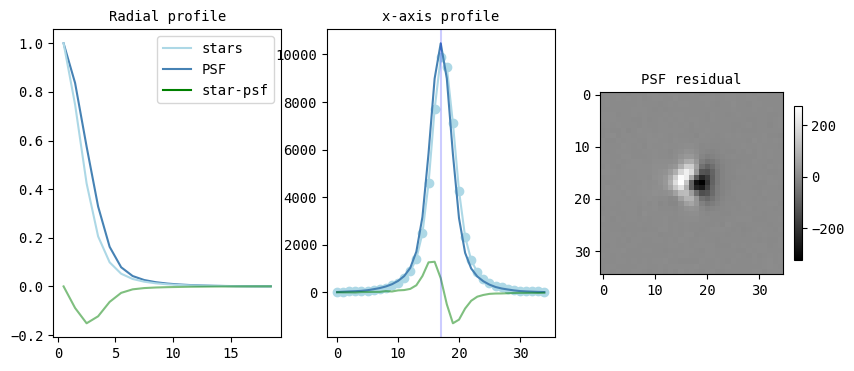

<Figure size 640x480 with 0 Axes>

In [96]:
starnum=0
psf1rp = profiles.RadialProfile(epsf1.data,xycen=stars[starnum].cutout_center,radii = np.arange(20))
starnrp = profiles.RadialProfile(stars[starnum].data,xycen=stars[starnum].cutout_center,radii = np.arange(20))
psf1rp.normalize("max")
starnrp.normalize("max")
fig,ax = plt.subplots(1,3,figsize=(10,4))
ax[0].plot(psf1rp.radius, psf1rp.profile,"steelblue")
ax[0].plot(starnrp.radius, starnrp.profile,"lightblue")
ax[0].plot(starnrp.radius, starnrp.profile-psf1rp.profile,"g", alpha=0.5)

ax[1].plot(np.sum(stars[starnum].data, axis=0), color="lightblue",marker="o")
shp = stars[starnum].shape[0]
cen = stars[starnum].cutout_center[0]
x,y =np.meshgrid(np.arange(shp), np.arange(shp))
psf = epsf1.evaluate(x=x,y=y,x_0=cen,y_0=cen,flux = stars[starnum].estimate_flux())
ax[1].plot(np.sum(psf, axis=0), "steelblue")
ax[1].plot(np.sum(psf, axis=0)-np.sum(stars[starnum].data, axis=0), "green", alpha=0.5)
ax[1].axvline(x=stars[starnum].cutout_center[0],c="b", alpha=0.2)

im2 = ax[2].imshow(-stars[starnum].compute_residual_image(epsf1))
fig.colorbar(im2, ax=ax[2], shrink=0.5)

fig = plt.figure()
legend_handles = [plt.Line2D([], [], color='lightblue', label='stars'),
                  plt.Line2D([], [], color='steelblue', label='PSF'),
                  plt.Line2D([], [], color='green', label='star-psf')]

[ax[i].set_title(['Radial profile','x-axis profile','PSF residual'][i]) for i in range(3)]

ax[0].legend(handles=legend_handles);

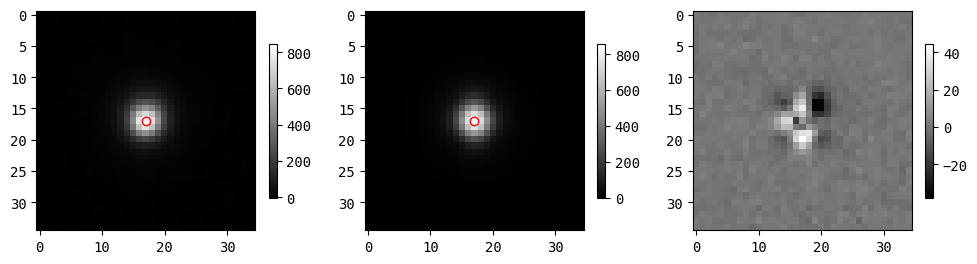

In [98]:
sn = 2
fig,ax = plt.subplots(1,3,figsize=(12,4))
norm = simple_norm(stars[i], 'log', percent=99.0)
im0 = ax[0].imshow(stars[sn])
x,y =np.meshgrid(np.arange(35), np.arange(35))
psf = epsf1.evaluate(x=x,y=y,x_0=17,y_0=17,flux = stars[sn].estimate_flux())
im1 = ax[1].imshow(psf)
im2 = ax[2].imshow(psf-stars[sn].data)
[ax[i].plot(17,17,"ro", mfc='none') for i in range(2)] 
[fig.colorbar([im0,im1,im2][i], ax = ax[i],shrink=0.5) for i in range(3)];

In [ ]:
df = pd.DataFrame([[stars[i].origin, np.max(stars[i].data), stars[i].flux] for i in range(len(stars))],columns=['pos',"maxI","flux"])
fig,ax = plt.subplots(1,2,figsize=(8,3))
[ax[i].hist([df.maxI,df.flux][i],histtype="step") for i in range(2)]
[ax[i].set_xlabel(['Peak intensity of star(count)','Total star flux'][i]) for i in range(2)]
[ax[i].set_ylabel('Number of stars') for i in range(2)]
fig.tight_layout();